# Predict gene knockout strategies
This notebook is based on https://cameo.bio/05-predict-gene-knockout-strategies.html

Basically, we're trying to find out if we can optimize a certain pathway by knocking other genes in the model.
We can predict gene knockout strategies with two algorithms:
* evolutionary algorithms (OptGene) 
* linear programming (OptKnock)

In [16]:
# Load library
from cameo import load_model, fba, phenotypic_phase_plane
from cameo.strain_design import OptGene, OptKnock
from cameo.visualization.plotting.with_plotly import PlotlyPlotter
plotter = PlotlyPlotter() # might require to install plotly

import escher
from escher import Builder

from IPython.display import IFrame

In [17]:
Builder()

Builder()

In [2]:
# custom script as cameo hasnt update its dependency with escher
def display_on_map(self, map_json, index=0, palette="YlGnBu"):
    with self._model:
        for ko in self.data_frame.loc[index, "reactions"]:
            self._model.reactions.get_by_id(ko).knock_out()
            try:
                fluxes = self._simulation_method(self._model, **self._simulation_kwargs) # for optgene
            except AttributeError:
                fluxes = fba(self._model) # for optknock
        builder = Builder(
            map_json = map_json,
            model = self._model,
            reaction_data = fluxes.fluxes.to_frame()
        )

    return builder

In [3]:
# load Chromobacterium model
model = load_model('../../results/iDB858_curated_phase2.xml')
model

<Model M_iDB858 at 0x192dc824df0>

In [4]:
s = fba(model)
path = "../../figures/WT_map_cycle1.html"
builder = Builder(
    map_json = "../../results/edited_map_reaction_phase3.json",
    model = model,
    reaction_data = s.fluxes.to_frame(),
    )
builder.save_html(path)
builder
#IFrame(src=path, width=700, height=600)

Builder(reaction_data=[{'rxn12008_c': 0.00233685938934557, 'rxn00541_c': 0.0, 'ACKr': 0.0, 'rxn01674_c': 0.0, …

This showed us the fluxes in wildtype. Note that the model does not have any fluxes towards hcn production.
! [map](../figures/WT_map.html)
## Phenotypic phase plane

In [5]:
wt_solution = model.optimize()
growth = wt_solution.fluxes["biomass1.12"]
hcn_production = wt_solution.fluxes["rDB00166_c"]

In [6]:
p = phenotypic_phase_plane(model, variables=['biomass1.12'], objective='rDB00166_c')
p.plot(plotter, points=[(growth, hcn_production)])

The phenotypic phase plane showed us a trade off between our target (in this case acetate production) with biomass. Implying that rewiring the flux to produce acetate will deteriorate growth.

## OPTGENE

In [7]:
optgene = OptGene(model)
result = optgene.run(target=model.reactions.rDB00166_c,
                     biomass=model.reactions.get_by_id("biomass1.12"),
                     substrate=model.metabolites.glc__D_e,
                     max_evaluations=5000,
                     population_size=1000,
                     plot=False)

Starting optimization at Thu, 21 Oct 2021 11:03:35


HBox()

Finished after 00:13:02


In [8]:
result

HBox()

The algorithm showed the reactions or genes that can be knocked out to acquire desired target production.

In [23]:
result.plot(plotter)

The phase plane showed us how the mutant area has shifted, reducing growth in favor of producing our target.

In [26]:
path = "../../figures/MT_optgene_map_cycle1_reactions2.html"
builder = display_on_map(result, "../../results/edited_map_reaction_phase3.json", index=2)
builder.save_html(path)
builder
#IFrame(src=path, width=700, height=600)

Builder(reaction_data=[{'rxn12008_c': 0.0023276551396467933, 'rxn00541_c': 0.0, 'ACKr': 0.0, 'rxn01674_c': 0.0…

You can also compare the fluxes map with the wildtype (shown previously). You can see that now, there is a flux towards our desired target

## OPTKNOCK

In [12]:
optknock = OptKnock(model, fraction_of_optimum=0.1)

c:\users\waff\appdata\local\programs\python\python39\lib\site-packages\cameo\strain_design\deterministic\linear_programming.py:118: UserWarning:

You are trying to run OptKnock with glpk_interface. This might not end well.

c:\users\waff\appdata\local\programs\python\python39\lib\site-packages\cobra\core\group.py:107: UserWarning:

need to pass in a list



Here, I use GLPK (GNU Linear Programming Kit) as my default solver for linux. You might want to try [Gurobi](https://www.gurobi.com/) instead.


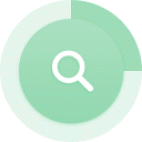

<IPython.core.display.Javascript object>

In [13]:
result = optknock.run(max_knockouts=1, target="rDB00166_c", biomass="biomass1.12")

In [14]:
result

HBox()

In [15]:
result.plot(plotter)

In [20]:
path = "../../figures/MT_optknock_map_cycle1_reactions1.html"
builder = display_on_map(result, "../../results/edited_map_reaction_phase3.json", index=1)
builder.save_html(path)
builder
#IFrame(src=path, width=700, height=600)

Builder(reaction_data=[{'rxn12008_c': 0.001251606450776984, 'rxn00541_c': 0.0, 'ACKr': 3.328085553766048, 'rxn…